In [1]:
import os
import pathlib
import random
import functools
import copy
import sys
import pickle
import tarfile
import operator
import math
import requests
import importlib

import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn import preprocessing
import scipy

import tensorflow as tf
import tensorflow_datasets as tfds


from tensorflow import keras
from tensorflow.keras import layers

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import flax

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

import neural_tangents as nt

import vit_jax

import adversarial_ntks as atk

[1 1 0 1 0 1 0 1 0 0]


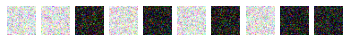

[1 0 1 0 1 1 0 0 0 1]


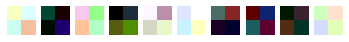

In [2]:
def generate_image_data(image_shape, m1, s1, m2, s2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        np.random.normal(loc=m1, scale=s1, size=(num_samples // 2,) + image_shape),
        np.random.normal(loc=m2, scale=s2, size=(num_samples // 2,) + image_shape)
    ]).clip(0, 1)
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def plot_images(xs, flat=True, channels=1):
    for i, x in enumerate(xs):
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(x, cmap="Greys", vmin=0, vmax=1)
        plt.axis("off")
    plt.show()

x_tmp, y_tmp = generate_image_data(
    image_shape=(32, 32, 3),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    num_samples=10
)
print(y_tmp)
plot_images(x_tmp)

x_tmp, y_tmp = generate_image_data(
    image_shape=(2, 2, 3),
    m1=0.1, s1=0.2,
    m2=0.9, s2=0.2,
    num_samples=10
)
print(y_tmp)
plot_images(x_tmp)

In [5]:
def run_experiment(
    image_shape,
    m1, s1,
    m2, s2,
    get_model,
    from_logits,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    attack_batch_size=256,
    num_train=10 ** 4,
    num_test=2000,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_image_data(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_train,
    )

    x_test, y_test = generate_image_data(
        image_shape=image_shape,
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_test,
    )
    
    model = get_model(x_train[0].shape)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=1,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
        clip_values=[x_test.min(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)

    x_test_advs = (np.take(x_test_adv, np.nonzero(y_test == 0), axis=0)[0],
        np.take(x_test_adv, np.nonzero(y_test == 1), axis=0)[0])
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc_0, _, adv_test_acc_1 = *model.evaluate(x_test_advs[0], np.zeros((x_test_advs[0].shape[0],)), verbose=0), \
        *model.evaluate(x_test_advs[1], np.ones((x_test_advs[1].shape[0],)), verbose=0)
    adv_test_accs = (adv_test_acc_0, adv_test_acc_1)
    adv_test_acc = (adv_test_accs[0] * x_test_advs[0].shape[0] + adv_test_accs[1] * x_test_advs[1].shape[0]) / y_test.shape[0]
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  accs :", adv_test_accs, adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
        x_test_advs=x_test_advs
    )

Epoch 1/5
157/157 [==============================] - 1s 7ms/step - loss: 0.5412 - accuracy: 0.5979 - val_loss: 0.3278 - val_accuracy: 0.9500
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.2705 - accuracy: 0.9718 - val_loss: 0.1375 - val_accuracy: 0.9945
Epoch 3/5
157/157 [==============================] - 1s 6ms/step - loss: 0.1138 - accuracy: 0.9974 - val_loss: 0.0670 - val_accuracy: 0.9985
Epoch 4/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0595 - accuracy: 0.9988 - val_loss: 0.0399 - val_accuracy: 0.9980
Epoch 5/5
157/157 [==============================] - 1s 6ms/step - loss: 0.0356 - accuracy: 0.9989 - val_loss: 0.0272 - val_accuracy: 0.9985
Nat train acc : 0.9991000294685364
Nat test  acc : 0.9984999895095825
Adv train acc : 0.0010000000474974513
Adv test  accs : (0.0, 0.0010000000474974513) 0.0005000000237487257
(1000, 2, 2, 1) (1000, 2, 2, 1)


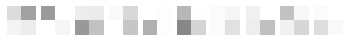

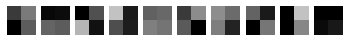

(1000, 2, 2, 1) (1000, 2, 2, 1)


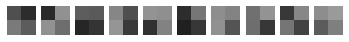

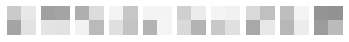

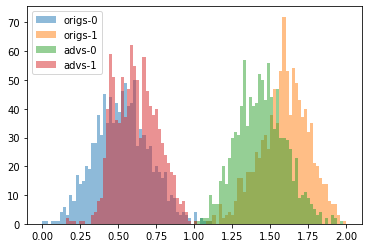

Max perturb norm: 1.0
Wall time: 17.6 s


In [12]:
%%time
IMG_DIM = 2
IMG_CHANNELS = 1
NORM_RANGE_MAX = IMG_DIM * IMG_CHANNELS ** 0.5
ATTACK_EPS = NORM_RANGE_MAX / 2
ATTACK_EPS_STEP = 0.4
ATTACK_ITERS = 40

res = run_experiment(
    image_shape=(IMG_DIM, IMG_DIM, IMG_CHANNELS),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(16, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=ATTACK_EPS,
    attack_eps_step=ATTACK_EPS_STEP,
    attack_iters=ATTACK_ITERS,
)

####

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0", range=(0,2))
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1", range=(0,2))
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0", range=(0,2))
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1", range=(0,2))
plt.legend()
plt.show()

print("Max perturb norm:", min(ATTACK_EPS, ATTACK_EPS_STEP * ATTACK_ITERS))

Epoch 1/5
157/157 [==============================] - 2s 7ms/step - loss: 0.5458 - accuracy: 0.5518 - val_loss: 0.4446 - val_accuracy: 0.5940
Epoch 2/5
157/157 [==============================] - 1s 6ms/step - loss: 0.4034 - accuracy: 0.8107 - val_loss: 0.3268 - val_accuracy: 0.9785
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.2925 - accuracy: 0.9641 - val_loss: 0.2374 - val_accuracy: 0.9935
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1927 - accuracy: 0.9992 - val_loss: 0.1648 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1339 - accuracy: 0.9998 - val_loss: 0.1150 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.0
Adv test  accs : (0.0, 0.0) 0.0
(1000, 32, 32, 3) (1000, 32, 32, 3)


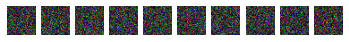

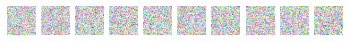

(1000, 32, 32, 3) (1000, 32, 32, 3)


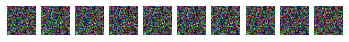

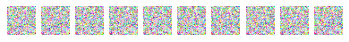

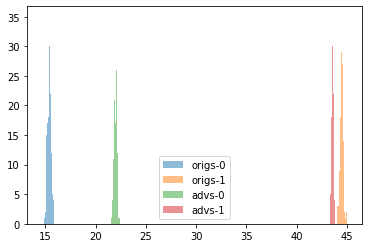

Max perturb norm: 16.0
Wall time: 19.9 s


In [11]:
%%time
IMG_DIM = 32
IMG_CHANNELS = 3
NORM_RANGE_MAX = IMG_DIM * IMG_CHANNELS ** 0.5
ATTACK_EPS = NORM_RANGE_MAX / 2
ATTACK_EPS_STEP = 0.4
ATTACK_ITERS = 40

res = run_experiment(
    image_shape=(IMG_DIM, IMG_DIM, IMG_CHANNELS),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(16, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=ATTACK_EPS,
    attack_eps_step=ATTACK_EPS_STEP,
    attack_iters=ATTACK_ITERS,
)

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0")
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1")
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0")
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1")
plt.legend()
plt.show()

print("Max perturb norm:", min(ATTACK_EPS, ATTACK_EPS_STEP * ATTACK_ITERS))

Epoch 1/5
157/157 [==============================] - 2s 8ms/step - loss: 0.5412 - accuracy: 0.5979 - val_loss: 0.3278 - val_accuracy: 0.9500
Epoch 2/5
157/157 [==============================] - 1s 6ms/step - loss: 0.2705 - accuracy: 0.9718 - val_loss: 0.1375 - val_accuracy: 0.9945
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1138 - accuracy: 0.9974 - val_loss: 0.0670 - val_accuracy: 0.9985
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0595 - accuracy: 0.9988 - val_loss: 0.0399 - val_accuracy: 0.9980
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0356 - accuracy: 0.9989 - val_loss: 0.0272 - val_accuracy: 0.9985
Nat train acc : 0.9991000294685364
Nat test  acc : 0.9984999895095825
Adv train acc : 0.0010000000474974513
Adv test  accs : (0.0, 0.0010000000474974513) 0.0005000000237487257
(1000, 2, 2, 1) (1000, 2, 2, 1)


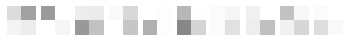

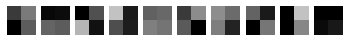

(1000, 2, 2, 1) (1000, 2, 2, 1)


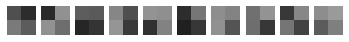

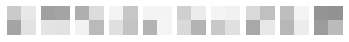

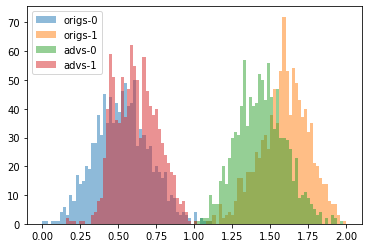

Max perturb norm: 1.0
Wall time: 16.8 s


In [13]:
%%time
IMG_DIM = 2
IMG_CHANNELS = 1
NORM_RANGE_MAX = IMG_DIM * IMG_CHANNELS ** 0.5
ATTACK_EPS = NORM_RANGE_MAX / 2
ATTACK_EPS_STEP = 0.4
ATTACK_ITERS = 40

res = run_experiment(
    image_shape=(IMG_DIM, IMG_DIM, IMG_CHANNELS),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(16, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=ATTACK_EPS,
    attack_eps_step=ATTACK_EPS_STEP,
    attack_iters=ATTACK_ITERS,
)

####

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0", range=(0,2))
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1", range=(0,2))
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0", range=(0,2))
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1", range=(0,2))
plt.legend()
plt.show()

print("Max perturb norm:", min(ATTACK_EPS, ATTACK_EPS_STEP * ATTACK_ITERS))

In [58]:
data = []
for a in range(20):
    norm = a / 10

    x, _ = generate_image_data(
        image_shape=(2, 2, 1),
        m1=0.5, s1=0.2,
        m2=0.5, s2=0.2,
        num_samples=1000
    )
    norms = np.linalg.norm(x.reshape((x.shape[0], -1)), ord=2, axis=-1)
    st = np.stack((norms,) * 2, axis=-1)
    # print(st.shape)
    st = st.reshape(st.shape + (1,))
    # print(st.shape)
    st = np.stack((st,) * 2, axis=2)
    # print(st.shape)
    x_normed = np.divide(x, st)
    # print(x_normed.shape)
    # print(np.linalg.norm(x_normed.reshape((x_normed.shape[0], -1)), ord=2, axis=-1))

    final_x = x_normed * norm
    data.append(res["model"].evaluate(final_x, np.ones((final_x.shape[0],)), verbose=0)[1])

print(data)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3700000047683716, 0.9039999842643738, 0.9800000190734863, 0.9990000128746033, 0.9980000257492065, 1.0, 1.0, 1.0, 1.0, 1.0]


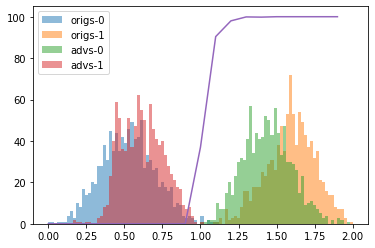

In [65]:
plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0", range=(0,2))
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1", range=(0,2))
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0", range=(0,2))
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1", range=(0,2))
plt.plot(np.arange(0, 20) / 10, np.array(data) * 100)
plt.legend()
plt.show()

Epoch 1/5
157/157 [==============================] - 2s 7ms/step - loss: 0.5412 - accuracy: 0.5979 - val_loss: 0.3278 - val_accuracy: 0.9500
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.2705 - accuracy: 0.9718 - val_loss: 0.1375 - val_accuracy: 0.9945
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1138 - accuracy: 0.9974 - val_loss: 0.0670 - val_accuracy: 0.9985
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0595 - accuracy: 0.9988 - val_loss: 0.0399 - val_accuracy: 0.9980
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.0356 - accuracy: 0.9989 - val_loss: 0.0272 - val_accuracy: 0.9985
Nat train acc : 0.9991000294685364
Nat test  acc : 0.9984999895095825
Adv train acc : 0.0010000000474974513
Adv test  accs : (0.0, 0.0010000000474974513) 0.0005000000237487257
(1000, 2, 2, 1) (1000, 2, 2, 1)


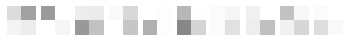

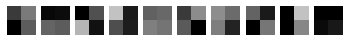

(1000, 2, 2, 1) (1000, 2, 2, 1)


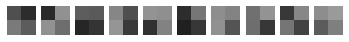

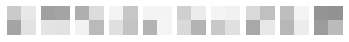

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36800000071525574, 0.9039999842643738, 0.9890000224113464, 1.0, 1.0, 0.9990000128746033, 1.0, 1.0, 1.0, 1.0]


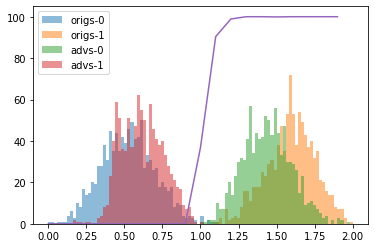

Max perturb norm: 1.0
Wall time: 21.4 s


In [66]:
%%time
IMG_DIM = 2
IMG_CHANNELS = 1
NORM_RANGE_MAX = IMG_DIM * IMG_CHANNELS ** 0.5
ATTACK_EPS = NORM_RANGE_MAX / 2
ATTACK_EPS_STEP = 0.4
ATTACK_ITERS = 40

res = run_experiment(
    image_shape=(IMG_DIM, IMG_DIM, IMG_CHANNELS),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(16, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=ATTACK_EPS,
    attack_eps_step=ATTACK_EPS_STEP,
    attack_iters=ATTACK_ITERS,
)

####

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

data = []
for a in range(20):
    norm = a / 10

    x, _ = generate_image_data(
        image_shape=(2, 2, 1),
        m1=0.5, s1=0.2,
        m2=0.5, s2=0.2,
        num_samples=1000
    )
    norms = np.linalg.norm(x.reshape((x.shape[0], -1)), ord=2, axis=-1)
    st = np.stack((norms,) * 2, axis=-1)
    # print(st.shape)
    st = st.reshape(st.shape + (1,))
    # print(st.shape)
    st = np.stack((st,) * 2, axis=2)
    # print(st.shape)
    x_normed = np.divide(x, st)
    # print(x_normed.shape)
    # print(np.linalg.norm(x_normed.reshape((x_normed.shape[0], -1)), ord=2, axis=-1))

    final_x = x_normed * norm
    data.append(res["model"].evaluate(final_x, np.ones((final_x.shape[0],)), verbose=0)[1])

print(data)

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0", range=(0,2))
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1", range=(0,2))
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0", range=(0,2))
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1", range=(0,2))
plt.plot(np.arange(0, 20) / 10, np.array(data) * 100)
plt.legend()
plt.show()

print("Max perturb norm:", min(ATTACK_EPS, ATTACK_EPS_STEP * ATTACK_ITERS))

Epoch 1/5
157/157 [==============================] - 2s 9ms/step - loss: 0.5458 - accuracy: 0.5518 - val_loss: 0.4446 - val_accuracy: 0.5940
Epoch 2/5
157/157 [==============================] - 1s 6ms/step - loss: 0.4034 - accuracy: 0.8107 - val_loss: 0.3268 - val_accuracy: 0.9785
Epoch 3/5
157/157 [==============================] - 1s 6ms/step - loss: 0.2925 - accuracy: 0.9641 - val_loss: 0.2374 - val_accuracy: 0.9935
Epoch 4/5
157/157 [==============================] - 1s 7ms/step - loss: 0.1927 - accuracy: 0.9992 - val_loss: 0.1648 - val_accuracy: 1.0000
Epoch 5/5
157/157 [==============================] - 1s 6ms/step - loss: 0.1339 - accuracy: 0.9998 - val_loss: 0.1150 - val_accuracy: 1.0000
Nat train acc : 1.0
Nat test  acc : 1.0
Adv train acc : 0.0
Adv test  accs : (0.0, 0.0) 0.0
(1000, 32, 32, 3) (1000, 32, 32, 3)


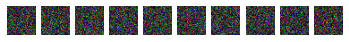

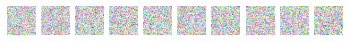

(1000, 32, 32, 3) (1000, 32, 32, 3)


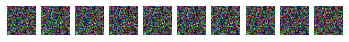

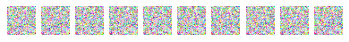

ValueError: operands could not be broadcast together with shapes (1000,2,2,1) (1000,32,32,3) 

In [70]:
%%time
IMG_DIM = 32
IMG_CHANNELS = 3
NORM_RANGE_MAX = IMG_DIM * IMG_CHANNELS ** 0.5
ATTACK_EPS = NORM_RANGE_MAX / 2
ATTACK_EPS_STEP = 0.4
ATTACK_ITERS = 40

res = run_experiment(
    image_shape=(IMG_DIM, IMG_DIM, IMG_CHANNELS),
    m1=0.2, s1=0.2,
    m2=0.8, s2=0.2,
    get_model=lambda input_shape: keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(16, activation="relu"),
            layers.Dense(2, activation="softmax"),
        ]
    ),
    from_logits=False,
    train_epochs=5,
    attack_norm=2,
    attack_eps=ATTACK_EPS,
    attack_eps_step=ATTACK_EPS_STEP,
    attack_iters=ATTACK_ITERS,
)

####

count = res["x_test_adv"].shape[0]
origs = (np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["test_data"][0], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(origs[0].shape, origs[1].shape)
plot_images(origs[0][:10])
plot_images(origs[1][:10])
advs = (np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 0), axis=0)[0],
    np.take(res["x_test_adv"], np.nonzero(res["test_data"][1] == 1), axis=0)[0])
print(advs[0].shape, advs[1].shape)
plot_images(advs[0][:10])
plot_images(advs[1][:10])

data = []
for a in range(20):
    norm = a / 10

    x, _ = generate_image_data(
        image_shape=(2, 2, 1),
        m1=0.5, s1=0.2,
        m2=0.5, s2=0.2,
        num_samples=1000
    )
    norms = np.linalg.norm(x.reshape((x.shape[0], -1)), ord=2, axis=-1)
    st = np.stack((norms,) * IMG_DIM, axis=-1)
    # print(st.shape)
    # print(st.shape)
    st = np.stack((st,) * IMG_DIM, axis=-1)
    st = np.stack((st,) * IMG_CHANNELS, axis=-1)
    # print(st.shape)
    x_normed = np.divide(x, st)
    # print(x_normed.shape)
    # print(np.linalg.norm(x_normed.reshape((x_normed.shape[0], -1)), ord=2, axis=-1))

    final_x = x_normed * norm
    data.append(res["model"].evaluate(final_x, np.ones((final_x.shape[0],)), verbose=0)[1])

print(data)

####

plt.hist(np.linalg.norm(origs[0].reshape((origs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-0", range=(0,2))
plt.hist(np.linalg.norm(origs[1].reshape((origs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="origs-1", range=(0,2))
plt.hist(np.linalg.norm(advs[0].reshape((advs[0].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-0", range=(0,2))
plt.hist(np.linalg.norm(advs[1].reshape((advs[1].shape[0], -1)), ord=2, axis=-1), bins=100, alpha=0.5, label="advs-1", range=(0,2))
plt.plot(np.arange(0, 20) / 10, np.array(data) * 100)
plt.legend()
plt.show()

print("Max perturb norm:", min(ATTACK_EPS, ATTACK_EPS_STEP * ATTACK_ITERS))